# Анализ данных сервиса аренды самокатов GoFast

А данном исследовании производится анализ данных сервиса аренды самокатов и их поездках. 

Для анализа используются данные о пользователях сервиса, об их поездках и о видах подписки на услуги сервиса.

Цель проекта: анализ имеющихся данных о сервисе и проверка гипотиез для повышения эффективности работы сервиса.

План работы:
1. Предобработка данных,
2. Исследовательский анализ данных пользователей по регионам, возрасту, наличию подписки.
3. Исследовательный анализ поездок по продолжительности и расстоянию. В общем и в зависимости от вида подписки.
4. Расчёт прибыли в зависиомсти от вида подписки.
5. Проверка гипотез о работе сервиса.

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats as st

#### Шаг 1. Загрузка данных

In [2]:
users = pd.read_csv('/datasets/users_go.csv')
rides = pd.read_csv('/datasets/rides_go.csv')
subsc = pd.read_csv('/datasets/subscriptions_go.csv')

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


In [5]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


In [7]:
subsc.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [8]:
subsc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Были загружены три датафрейма:
1. с данными о пользователях,
2. с данными о поездках,
3. с данными о видах подписки.

#### Шаг 2. Предобработка данных

In [9]:
#приведём столбец date к типу даты
rides['date'] = pd.to_datetime(rides['date'])

In [45]:
#проверим, за какой перод у нас данные
print(rides['date'].min())
print(rides['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


In [46]:
#создадим столбец с номером месяца. Т.к. данные за один год, учитывать год не будем
rides['month'] = rides['date'].dt.month 

In [11]:
#пропущенных данных в датафреймах нет, исходя из данных, полученных с помощью функции info(). 
#Проверим, нет ли там значений Nan или других, которые могут повлиять на исследование.
print(users['age'].describe())
print(users['city'].unique())
print(users['subscription_type'].unique())

count    1565.000000
mean       24.922045
std         4.553496
min        12.000000
25%        22.000000
50%        25.000000
75%        28.000000
max        43.000000
Name: age, dtype: float64
['Тюмень' 'Омск' 'Москва' 'Ростов-на-Дону' 'Краснодар' 'Пятигорск'
 'Екатеринбург' 'Сочи']
['ultra' 'free']


In [12]:
#то же сделаем для датафрейма rides
print(rides.describe())

            user_id      distance      duration         month
count  18068.000000  18068.000000  18068.000000  18068.000000
mean     842.869936   3070.659976     17.805011      6.486772
std      434.734317   1116.831209      6.091051      3.437410
min        1.000000      0.855683      0.500000      1.000000
25%      487.000000   2543.226360     13.597563      4.000000
50%      889.000000   3133.609994     17.678395      6.000000
75%     1213.250000   3776.222735     21.724800      9.000000
max     1534.000000   7211.007745     40.823963     12.000000


In [43]:
#округлим данные в поле с расстоянием поездок
rides['distance'] = round(rides['distance'],2)

In [13]:
#проверим явные дубликаты
users[users.duplicated()].count()

user_id              31
name                 31
age                  31
city                 31
subscription_type    31
dtype: int64

In [14]:
#явные дубликаты есть, проверим их долю
(users[users.duplicated()].count())/(users.count())
#2% дубликатов - их удаление не повлияет на анализ данных

user_id              0.019808
name                 0.019808
age                  0.019808
city                 0.019808
subscription_type    0.019808
dtype: float64

In [15]:
#удалим такие дубликаты
users = users.drop_duplicates().reset_index(drop=True)
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [16]:
#то же сделаем для датафрейма rides
rides[rides.duplicated()].head()
#здесь дубликатов нет

,user_id,distance,duration,date,month


В результате предобработки данных были удалены дубликаты, добавлен столбец с месяцем поездки. Пропущенных значений не обнаружено.

#### Шаг 3. Исследовательский анализ данных

In [17]:
#изучим частоту встречаемости городов
users.groupby('city')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False)

,city,user_id
4,Пятигорск,219
0,Екатеринбург,204
5,Ростов-на-Дону,198
1,Краснодар,193
6,Сочи,189
3,Омск,183
7,Тюмень,180
2,Москва,168


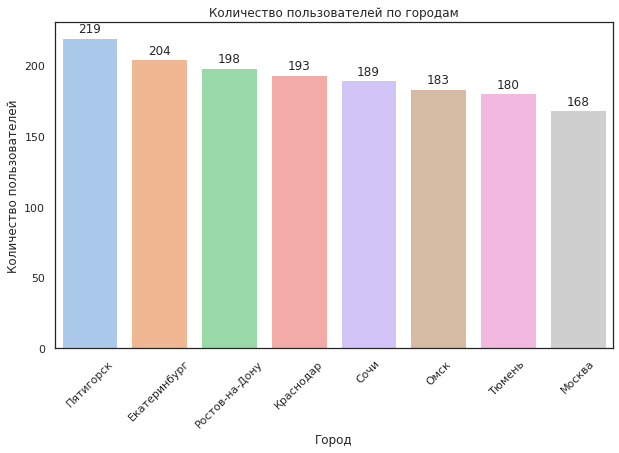

In [18]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_palette('pastel')
sns.set_style('white')
city_plot = sns.barplot(x='city', y='user_id', data = users.groupby('city')['user_id'].count().reset_index().sort_values(by='user_id', ascending=False))

city_plot.set(xlabel ="Город", ylabel = "Количество пользователей", title ='Количество пользователей по городам');
city_plot.set_xticklabels(city_plot.get_xticklabels(), rotation=45);
for p in city_plot.patches:
    city_plot.annotate(format(p.get_height(), '.0f'), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points');

Наибольшей популярностью сервис пользуется в городах Пятигорск и Екатеринбург - там более 200 пользователей в каждом городе. Близко к этому значению количество пользователей в Ростове-на-Дону и Краснодаре. Немного меньше - в Сочи, Омске и Тюмени. Меньше всего пользователей в столице.

In [19]:
users_plot = users.groupby('subscription_type')['user_id'].count().reset_index()
users_plot['percentage'] = round((users_plot['user_id']/users_plot['user_id'].sum()) * 100, 2)
users_plot.head()

,subscription_type,user_id,percentage
0,free,835,54.43
1,ultra,699,45.57


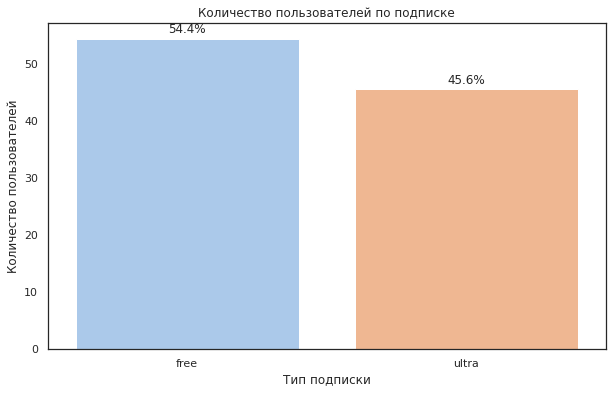

In [20]:
subsc_plot = sns.barplot(x='subscription_type', y='percentage', data = users_plot)

subsc_plot.set(xlabel ="Тип подписки", ylabel = "Количество пользователей", title ='Количество пользователей по подписке');

for p in subsc_plot.patches:
    subsc_plot.annotate('{:.1f}%'.format(p.get_height()), 
                       (p.get_x() + p.get_width() / 2., p.get_height()), 
                       ha = 'center', va = 'center', 
                       xytext = (0, 9), 
                       textcoords = 'offset points')

Пользователей с подпиской лишь немного меньше пользователей без подписки - разница менее 10%.

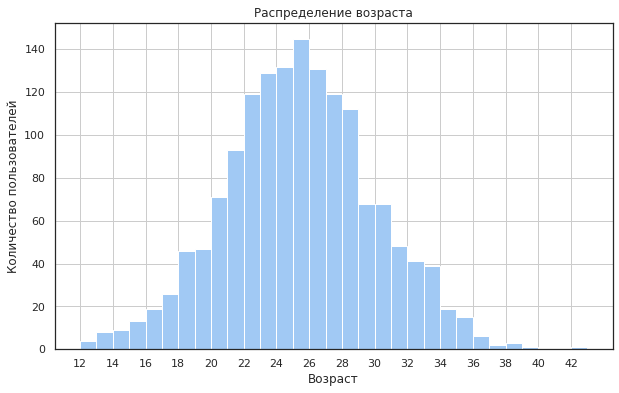

In [21]:
#изучим распределение возраста
users['age'].hist(bins=31)
plt.xlabel('Возраст');
plt.ylabel('Количество пользователей');
plt.title('Распределение возраста')
plt.xticks(range(12, 43, 2));

Распределение близко к нормальному с пиком в 25 лет. Минимальный возраст - 12 лет, максимальный - 43. Большая чась пользователей лежит в промежутке от 20 до 32 лет.

In [22]:
#изучим данных по расстоянию поездок
rides['distance'].describe()

count    18068.000000
mean      3070.659976
std       1116.831209
min          0.855683
25%       2543.226360
50%       3133.609994
75%       3776.222735
max       7211.007745
Name: distance, dtype: float64

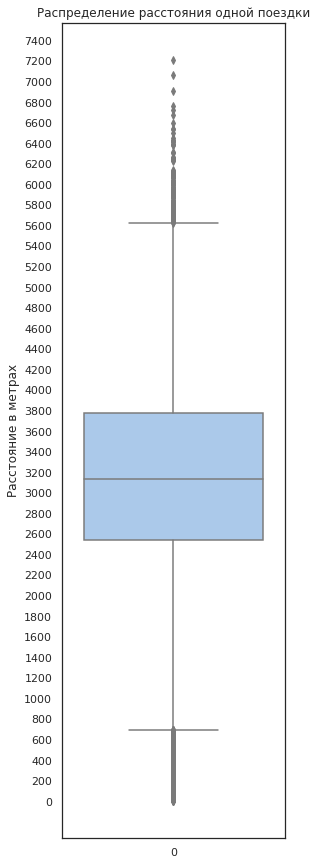

In [23]:
sns.set(rc={'figure.figsize':(4,15)})
sns.set_palette('pastel')
sns.set_style('white')
distance_plot = sns.boxplot(data=rides['distance'])
distance_plot.set(ylabel = "Расстояние в метрах", title ='Распределение расстояния одной поездки');
plt.yticks(range(0, 7500, 200));

Среднее расстояние одной поездки - 3 070 метров. Медианное - 3 133. Медиана и средняя очень близки. Это значит, что значительных выбросов в данных нет. Максимальное расстояние - 7 211 метров, минимальное - менее метра. Таких значений не слишком много. Основная масса поездок лежит между 2 543 метрами и 3 776 метрами.

Разброс не просто так не такой уж большой. Во-первых, у самокатов есть максимальное расстояние, которое они могут проехать до того, как аккумулятор нужно будет зарядить. Во-вторых, самокаты не столь удобны для передвижения на большие расстояния.

In [24]:
#изучим данные по длительности поездок
rides['duration'].describe()

count    18068.000000
mean        17.805011
std          6.091051
min          0.500000
25%         13.597563
50%         17.678395
75%         21.724800
max         40.823963
Name: duration, dtype: float64

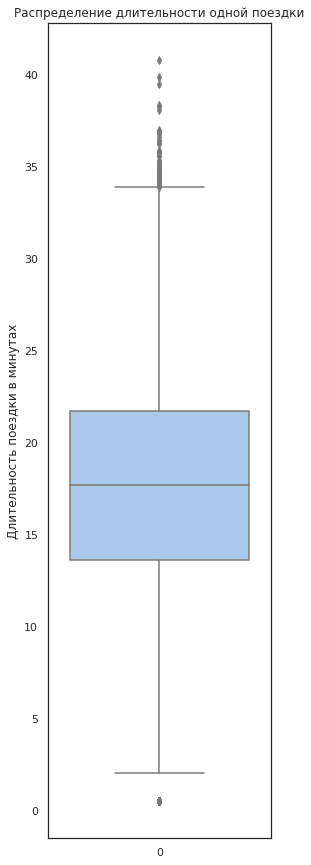

In [25]:
duration_plot = sns.boxplot(data=rides['duration'])
duration_plot.set(ylabel = "Длительность поездки в минутах", title ='Распределение длительности одной поездки');

Среднее и медианное значение длительности близки - 17.8 минут и 17.7 соответственно. Основная масса поездок длится от 14 до 22 минут. Иногда поездки длятся до 40 минут. Минимальная длительность (не считая выбросов) - от 2 минут. Причины такого небольшого разброса те же, что и небольшого разброса расстояний.

#### Шаг 4. Объединение данных

In [26]:
#data_subcategory = data.merge(subcategory_dict, on='subcategory_id', how='left')
df = users.merge(rides, on='user_id', how = 'left').merge(subsc, on='subscription_type', how='left')
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [27]:
#проверим, чтобы данные не потерялись.
#т.к. самое большое количество строк в rides, количество строк в новом датафрейме должно совпадать с количеством строк в rides.
df.info()
#так и есть.

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int64         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(3)
memory usage: 1.8+ MB


In [28]:
#создадим датафрейм с пользователями без подписки
df_free = df[df['subscription_type'] == 'free'].reset_index(drop=True)
df_free.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,700,Айдар,22,Омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
1,700,Айдар,22,Омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
2,700,Айдар,22,Омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
3,700,Айдар,22,Омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
4,700,Айдар,22,Омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [29]:
#и с подпиской
df_ultra = df[df['subscription_type'] == 'ultra'].reset_index(drop=True)
df_ultra.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,Кира,22,Тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,Кира,22,Тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,Кира,22,Тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,Кира,22,Тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,Кира,22,Тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Визуализируем данные о расстоянии поездок пользователей с подпиской и без неё

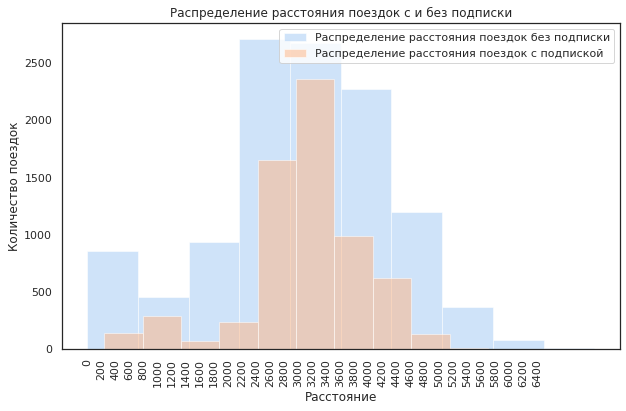

In [47]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_palette('pastel')
sns.set_style('white')
plt.hist(df_free['distance'], alpha=0.5, label='Распределение расстояния поездок без подписки')
plt.hist(df_ultra['distance'], alpha=0.5, label='Распределение расстояния поездок c подпиской') 
plt.xlabel('Расстояние');
plt.title('Распределение расстояния поездок с и без подписки');
plt.ylabel('Количество поездок');
plt.xticks(range(0, 6500, 200), rotation=90);
plt.legend(loc='best');


Из графика видно, что поездок без подписки в целом больше, чем поездок с подпиской. Основная масса поездок без подписки - от 2200 м до 4400 м. Распределение близко к нормальному, если не считать небольшой выброс в поездках от 0 до 700 метров. Без подписки заметно больше поездок на короткие расстояния (относительного общего количества поездок без подписки), чем поездок на малые расстояния с подпиской. 

С подпиской люди заметно чаще ездят на расстояние 3000-3500 метров. Значительный вес также имеют поездки на расстояние 2400-3000 метров. В целом распределение тоже близко к нормальному с пиком на 3000-3500 метров.

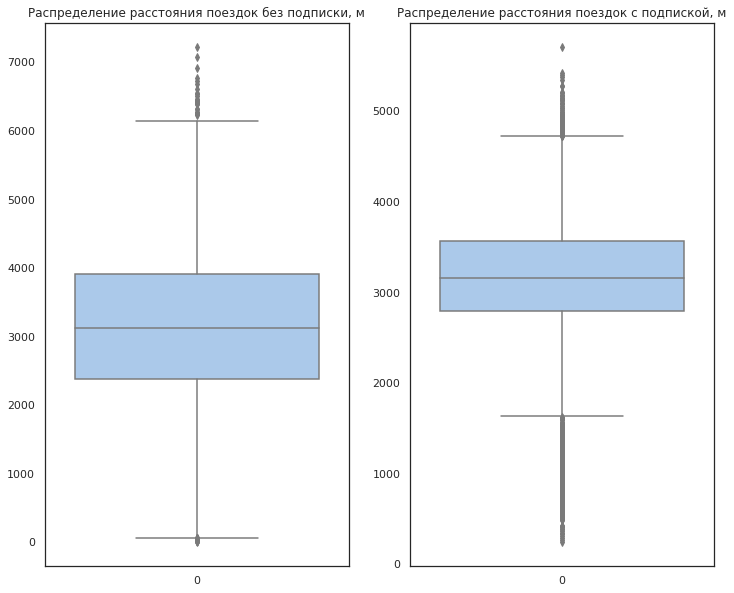

In [31]:
sns.set(rc={'figure.figsize':(12,10)})
sns.set_palette('pastel')
sns.set_style('white')
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=df_free['distance'], ax=axes[0]).set_title('Распределение расстояния поездок без подписки, м')
sns.boxplot(data=df_ultra['distance'], ax=axes[1]).set_title('Распределение расстояния поездок с подпиской, м')

plt.show()


Медианное значение расстояния поездок с и без подписки очень близки - примерно 3100 м. Также, как было видно на гистограмме, видим, что разброс основной массы значений расстояния поездок без подписки больше, чем поездок с подпиской. Основная масса значений поездок без подписки лежит между 2200 м и 3900 м. С подпиской - между 2900 м и 3500 м. 

Визуализируем данные о длительности поездок пользователей с подпиской и без неё

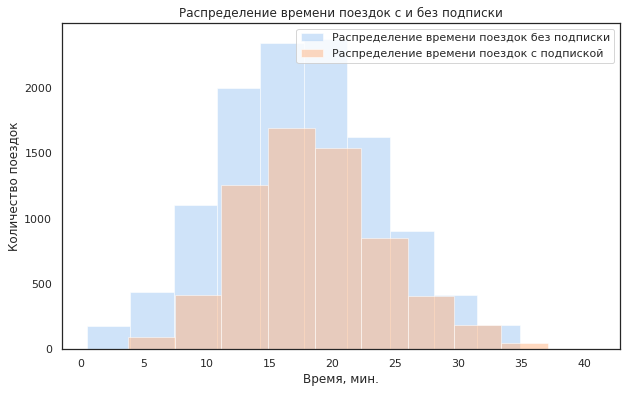

In [48]:
sns.set(rc={'figure.figsize':(10,6)})
sns.set_palette('pastel')
sns.set_style('white')
plt.hist(df_free['duration'], alpha=0.5, label='Распределение времени поездок без подписки')
plt.hist(df_ultra['duration'], alpha=0.5, label='Распределение времени поездок c подпиской') 
plt.title('Распределение времени поездок с и без подписки');
plt.xlabel('Время, мин.');
plt.ylabel('Количество поездок');
plt.legend(loc='best');

Из графика видно, что поездок пользователей без подписки было больше, чем пользователей с подпиской.

Оба распределения близки к нормальному. Пик распределения времени поездок пользователей без подписки - 18 - 21 минута. Пользователи с подпиской же чаще ездят от 15 до 18 минут.

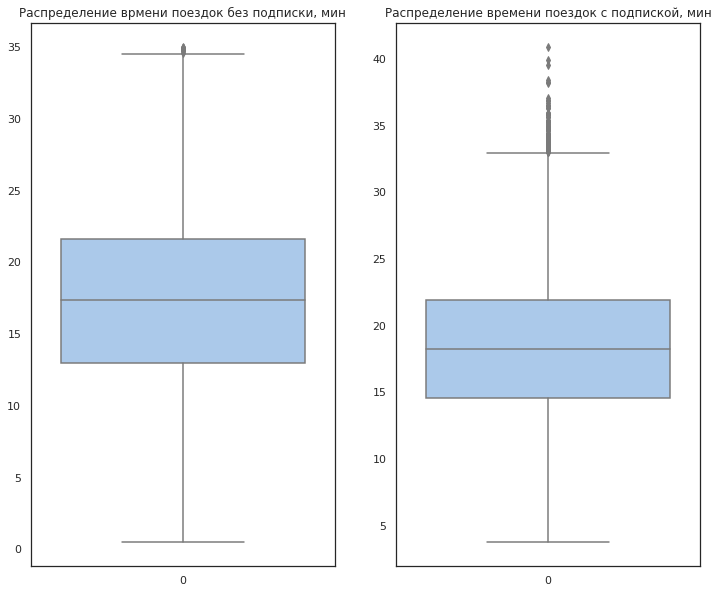

In [33]:
sns.set(rc={'figure.figsize':(12,10)})
sns.set_palette('pastel')
sns.set_style('white')
fig, axes = plt.subplots(1, 2)
sns.boxplot(data=df_free['duration'], ax=axes[0]).set_title('Распределение врмени поездок без подписки, мин')
sns.boxplot(data=df_ultra['duration'], ax=axes[1]).set_title('Распределение времени поездок с подпиской, мин')

plt.show()

Медианные значения времени поездок с подпиской и без нее достаточно близки - 17-18 минут. Разброс значений опять же больше у пользователей без подписки.

#### Шаг 5. Подсчёт выручки

In [34]:
#создадим датафрейм с агрегированными данными пользователей по месяцам. 
df_agg = df.pivot_table(index=['user_id', 'month'], values=['distance', 'duration', 'name', 'subscription_type'], aggfunc={'distance':sum, 'duration':sum, 'name':len, 'subscription_type': min}).reset_index()
df_agg.columns = ['user_id', 'month', 'agg_distance', 'agg_duration', 'count', 'subscription_type']
df_agg.head()

,user_id,month,agg_distance,agg_duration,count,subscription_type
0,1,1,7027.511294,41.416640,2,ultra
1,1,4,754.159807,6.232113,1,ultra
2,1,8,6723.470560,44.776802,2,ultra
3,1,10,5809.911100,31.578017,2,ultra
4,1,11,7003.499363,53.397424,3,ultra


In [35]:
#округлим продолжительность поездок
df_agg['agg_duration'] = np.ceil(df_agg['agg_duration'])
df_agg.head()

,user_id,month,agg_distance,agg_duration,count,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,45.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,54.0,3,ultra


In [36]:
#посчитаем прибыль по каждому пользователю по месяцам
def revenue(row):
    if row['subscription_type'] == 'ultra':
        return 6 * row['agg_duration'] + 199
    elif row['subscription_type'] == 'free':
        return 8 * row['agg_duration'] + 50 * row['count']
    else:
        0

df_agg['revenue'] = df_agg.apply(revenue, axis=1)
df_agg.head()

,user_id,month,agg_distance,agg_duration,count,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,45.0,2,ultra,469.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,54.0,3,ultra,523.0


Создан датафрейм с данными, сгруппированными по пользователям и месяцу поездки. Рассчитана выручка по каждому пользователю за месяц.

#### Шаг 6. Проверка гипотез

##### Гипотеза: пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Нулевая гипотеза: Время поездки пользователей с подпиской ultra **равно** времени поездки пользователей без подписки

Альернативная гипотеза: Время поездки пользователей с подпиской **больше** времени поездки пользователей без поездки

Уровень статистической значимости установим 5%.

In [37]:
ultra = df_ultra['duration'] 
free = df_free['duration']

results = st.ttest_ind(ultra, free, alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

1.2804098316645618e-34
Отвергаем нулевую гипотезу


Гипотезу о том, что время поездки пользователей с подпиской равно врмени поездки пользователей без подписки, нужно отвергнуть.
Можно предположить, что средняя продолжительность поездки пользователя с подпиской больше продолжительности поездки пользователя без подписки.

##### Гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, превышает 3130 метров

Нулевая гипотеза: среднее расстояние поездки пользователей с подпиской **равно** 3130 м.

Альтернативная гипотеза: среднее расстояние поездки пользователей с подпиской **больше** 3130 м.

Уровень статистической значимости установим 5%.

In [50]:
ultra_distance = df_ultra['distance']

value = 3130

alpha = 0.05

results = st.ttest_1samp(ultra_distance, value, alternative='greater')
    
print(results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

0.9195368847849785
Не удалось отвергнуть нулевую гипотезу


Отвергнуть гипотезу о том, что среднее расстояние поездки пользователя с подпиской равно 3130 метров, нельзя. Есть основания утверждать, что среднее расстояние с подпиской не превышает 3130 метров.

##### Гипотеза: помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки

Нулевая гипотеза: выручка от пользоватлей с подпиской **равна** выручке от пользователей без подписки

Альтернативная гипотеза: выруска от пользователей с подпиской **больше** выручки от пользоватлей с подпиской

Уровень статистической значимости установим 5%.

In [39]:
ultra_revenue = df_agg[df_agg.subscription_type == 'ultra']['revenue']
free_revenue = df_agg[df_agg.subscription_type == 'free']['revenue']

results = st.ttest_ind(ultra_revenue, free_revenue,alternative = 'greater')

alpha = 0.05

print(results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Не удалось отвергнуть нулевую гипотезу')

2.8130926188487286e-35
Отвергаем нулевую гипотезу


Нельзя утверждать, что выручка от пользователей с подпиской равна выручке от пользователей без подписки. Можно предполагать, что выручка от пользователей с подпиской больше, чем от пользоватлей без неё.

#### Выводы

Загрузили 3 датафрейма: с пользователями, информацией о поездках, информацией о подписках.

Проверили данные на пропуски, их не оказалось ни в одной таблице. Поменяли тип данных у столбца date из датафрейма data_riders к типу даты. Также добавили столбец month с номером месяца. Удалили дубликаты строк из датафрейма с пользователями.

Была проведена предобработка данных из трёх датафреймов.

В результате исследовательського анализа данных были сделаны следующие выводы:
1. Всего сервис аренды самокатов представлен в 8 городах. Больших различий в количестве пользователей нет. Наибольшей популярностью сервис пользуется в городах Пятигорск и Екатеринбург. Меньше всего пользователей в столице. 
2. Пользователей, которые не использую подписку - около 54%. Остальные оплачивают ежемесячную подписку.
3. Возраст пользователей: большая чась пользователей лежит в промежутке от 20 до 32 лет.
4. Среднее расстояние одной поездки - 3 070 метров. Основная масса поездок лежит между 2 500 метрами и 3 800 метрами.
5. Среднее значение длительности поездки - около 18 минут. Основная масса поездок длится от 14 до 22 минут.

Выделены данные для пользователей с подпиской и без неё. 
Были визуализированы данные, из которых следует:
1. Расстояние поездки: Основная масса поездок без подписки - от 2200 м до 4400 м. Распределение близко к нормальному. Пользователи с подпиской чаще всего ездят на расстояние 3000-3500 метров. Распределение также близко к нормальному. Медианное значение расстояния поездок с и без подписки очень близки - примерно 3100 м.
2. Длительность поездки:  Пик распределения времени поездок пользователей без подписки - 18 - 21 минута. Пользователи с подпиской же чаще ездят от 15 до 18 минут. Медианные значения времени поездок с подпиской и без нее достаточно близки - 17-18 минут. Оба распределения близки к нормальному.


Был создан датафрейм с данными о помесячной выручке по каждому пользователю.

Были проверены следующие гипотезы:
1. пользователи с подпиской тратят больше времени на поездки, чем пользователи без подписки.

Гипотезу о том, что время поездки пользователей с подпиской равно врмени поездки пользователей без подписки, нужно отвергнуть.
Можно предположить, что средняя продолжительность поездки пользователя с подпиской больше продолжительности поездки пользователя без подписки.
Хотя график и говорит об обратном.

2. среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров.

Отвергнуть гипотезу о том, что среднее расстояние поездки пользователя с подпиской равно 3130 метров, нельзя. Есть основания утверждать, что среднее расстояние с подпиской не превышает 3130 метров.

3. помесячная выручка от пользователей с подпиской выше, чем от пользователей без подписки.

Нельзя утверждать, что выручка от пользователей с подпиской равна выручке от пользователей без подписки. Можно предполагать, что выручка от пользователей с подпиской больше, чем от пользоватлей без неё.

Вывод: можно сказать, что подписка влияет на длительность и расстояние поездки, но это влияние не слишком велико. Однако статистический анализ показал, что пользователи с подпиской выгоднее для сервиса, поэтому стоит уделить внимание привлечению новых пользователей с подпиской.